# Show and Tell: A Neural Image Caption Generator

Automatically describing the content of an image is a fundamental problem in AI that connects computer vision and natural language processing. In this task, we will be looking into how we can use CNNs and RNNs to build an Image Caption Generator.

Specifically, you will be implementing and training the model [in this paper](https://arxiv.org/abs/1411.4555) with TensorFlow/Keras on one of the datasets mentioned in the paper.

To lighten the burden on training the network, you can use any pretrained network in [tf.keras.applications](https://www.tensorflow.org/api_docs/python/tf/keras/applications).

# Implementation

We use Flickr8k dataset for this lab, which has 6000 train images, 1000 validation images and 1000 test images. Each of the images has 5 captions.

Install tensorflow-gpu v. 2.0 and pgrade to the newest version of Keras

In [ ]:
!pip install tensorflow-gpu==2.0
!pip install --upgrade keras

Mount the Google Drive directory that stores our dataset. The same directory is used later for storing logs and weight files.

The directory is available via the following link: https://drive.google.com/open?id=1ImbDGCNwZ55V9FV8F-Dgm5ZGMMItLHn-

In [ ]:
# EXECUTE THE FOLLOWING CODE JUST ONCE PER SESSION
from google.colab import drive

drive.mount('/content/drive')
!unzip -q "/content/drive/My Drive/Scalable machine learning and deep learning/Lab 2/Flickr8k_Dataset.zip" -d "images/"
!unzip -q "/content/drive/My Drive/Scalable machine learning and deep learning/Lab 2/Flickr8k_text.zip" -d "captions/"

Initialize the path constants that will be used throughout the implementation code.

In [ ]:
import tensorflow as tf
from tensorflow import keras

project_path_drive = "/content/drive/My Drive/Scalable machine learning and deep learning/Lab 2/"
images_dir_path = "images/"
text_dir_path = "captions/"
train_list_file_path = text_dir_path + "Flickr_8k.trainImages.txt"
valid_list_file_path = text_dir_path + "Flickr_8k.devImages.txt"
test_list_file_path = text_dir_path + "Flickr_8k.testImages.txt"
image_captions_file_path = text_dir_path + "Flickr8k.token.txt"

# Preprocess data

We use a pre-trained Inception V3 CNN model for image classification. The model is pre-trained on the ImageNet dataset.

We remove the topmost softmax layer as we are not interested in the classification. We are interested in the features produced by the second last layer.

In [ ]:
from keras.applications import InceptionV3
from keras.models import Model

inceptionV3 = InceptionV3(weights = 'imagenet')

# pop the last softmax layer and freezing the remaining layers
inceptionV3.layers.pop()

# fix the layers' weights so that they are not updated during training
for layer in inceptionV3.layers:
    layer.trainable = False

output_layer = inceptionV3.layers[-1].output

# build the CNN model that we will use later
finalCnnModel = Model(inputs = inceptionV3.input, outputs = output_layer, name = 'Pretrained_CNN_final')

Declare the utility procedure for extracting text from a given file path:

In [ ]:
def loadFileText(filePath):
  file = open(filePath, 'r')
  text = file.read()
  file.close()
  return text

Declare function *getImageFeatures*. It returns features for images that are listed in file *imageTitlesFileName*. By image features we mean the output of the second last layer of the pretrained Inception V3.

In [ ]:
import numpy as np
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.inception_v3 import preprocess_input

# the size of image that is required by Inception V3
CNN_INPUT_SIZE = 299

def getImageFeatures(imageTitlesFileName):
  imgTitles = loadFileText(imageTitlesFileName)
  imgFeatures = dict()

  for imgTitle in imgTitles.split("\n"):
    if imgTitle is not "":
      img = load_img(images_dir_path + imgTitle, target_size = (CNN_INPUT_SIZE, CNN_INPUT_SIZE))
      # get the array of image pixels
      imgArray = img_to_array(img)
      # reshape imgArray so that it matches the CNN input
      imgArray = imgArray.reshape((1, imgArray.shape[0], imgArray.shape[1], imgArray.shape[2]))
      # each image array should undergo additional preprocessing before being fed to the model
      imgArrayPreprocessed = preprocess_input(imgArray)

      # obtain predictions (i.e. features) for the image 
      imgPredictions = finalCnnModel.predict(imgArrayPreprocessed, verbose = 1)
      # reshape the image features from (1, 2048) to (2048, )
      imgFeatures[imgTitle] = np.reshape(imgPredictions, imgPredictions.shape[1])

  return imgFeatures

We have to compute image features for all images if they are not computed yet. Then we store the the features map files at Google Drive.

In [ ]:
# EXECUTE THIS CELL ONLY ONCE!

import pickle
from pickle import dump

imgFeaturesTrain = getImageFeatures(train_list_file_path)
imgFeaturesValid = getImageFeatures(valid_list_file_path)
imgFeaturesTest = getImageFeatures(test_list_file_path)

Save image features on Google Drive
with open(project_path_drive + "img_features_train.pkl", "wb") as trainImgFeaturesFile:
    pickle.dump(imgFeaturesTrain, trainImgFeaturesFile)
with open(project_path_drive + "img_features_valid.pkl", "wb") as validImgFeaturesFile:
    pickle.dump(imgFeaturesValid, validImgFeaturesFile)
with open(project_path_drive + "img_features_test.pkl", "wb") as testImgFeaturesFile:
    pickle.dump(imgFeaturesTest, testImgFeaturesFile)


If the features are already stored in the files, we should load them.

In [ ]:
import pickle
from pickle import load

with open(project_path_drive + "img_features_train.pkl", "rb") as trainImgFeaturesFile:
    imgFeaturesTrain = load(trainImgFeaturesFile)
with open(project_path_drive + "img_features_valid.pkl", "rb") as validImgFeaturesFile:
    imgFeaturesValid = load(validImgFeaturesFile)
with open(project_path_drive + "img_features_test.pkl", "rb") as testImgFeaturesFile:
    imgFeaturesTest = load(testImgFeaturesFile)

Create map *imgCaptions*  that contains image titles as keys and a list of the 5 captions for the corresponding image as values.

In [ ]:
captionsLines = loadFileText(image_captions_file_path)
imgCaptions = dict()

for caption in captionsLines.split('\n'):
  if caption is not "":
    tokens = caption.split("\t")
    imgTitle = tokens[0].split("#")[0]
    captionString = tokens[1]

    if imgTitle not in imgCaptions:
      imgCaptions[imgTitle] = list()
    
    imgCaptions[imgTitle].append(captionString)

Perform data cleaning for all image captions in *imgCaptions*.

In [ ]:
import string

for imgTitle, captionsList in imgCaptions.items():
  for index, caption in enumerate(captionsList):
    # remove punctuation (commas, dots and other signs)
    caption = caption.translate(str.maketrans('', '', string.punctuation))
    
    wordsList = caption.split()

    # translate words to lower-case
    wordsList = [word.lower() for word in wordsList]
    # remove 1-character words (for example, "a")
    wordsList = [word for word in wordsList if len(word) > 1]
    # remove tokens with numbers in them
    wordsList = [word for word in wordsList if word.isalpha()]

    captionsList[index] =  ' '.join(wordsList)

Load titles of training, validation and test images into separate lists *trainImgList*, *validImgList* and *testImgList*.

In [ ]:
def load_img_titles(filePath):
  imgLines = loadFileText(filePath)
  imgList = list()
  for imgTitle in imgLines.split('\n'):
    if imgTitle is not "":
      imgList.append(imgTitle)
  return imgList

trainImgList = load_img_titles(train_list_file_path)
validImgList = load_img_titles(valid_list_file_path)
testImgList = load_img_titles(test_list_file_path)

Enhance each caption with special words **startseq** and **endseq** and store them in maps *trainImgCaptions*, *validImgCaptions* and *testImgCaptions*.

In [ ]:
def enhance_with_start_end(imgTitlesList):
  captions = dict()
  for imgTitle in imgTitlesList:
    captions[imgTitle] = list()
    for caption in imgCaptions[imgTitle]:
      caption = "startseq " + caption + " endseq"
      captions[imgTitle].append(caption)
  return captions

trainImgCaptions = enhance_with_start_end(trainImgList)
validImgCaptions = enhance_with_start_end(validImgList)
testImgCaptions = enhance_with_start_end(testImgList)

Form the vocabulary of words training captions.

(**Note**: special words *startseq* and *endseq* are considered as well)

In [ ]:
vocabTrain = set()
for key in trainImgList:
  [vocabTrain.update(caption.split()) for caption in trainImgCaptions[key]]
  
vocabTrainSize = len(vocabTrain)
print('Vocabulary size: %d' % vocabTrainSize)

Vocabulary size: 7578


We consider rare words as outliers because it helps to reduce the number of errors.

We remove all words that are encountered in training captions less than 5 times. 

In [ ]:
FREQ_THRESHOLD = 5

# determine the set of frequent words
wordCounts = dict()
for imgTitle in trainImgList:
  for caption in trainImgCaptions[imgTitle]:
    for word in caption.split():
      wordCounts[word] = wordCounts.get(word, 0) + 1

vocabTrain = [word for word in wordCounts if wordCounts[word] >= FREQ_THRESHOLD]
vocabTrainSize = len(vocabTrain)
print("Reduced vocabulary size: %d" % vocabTrainSize)

# remove non-frequent words from training captions
for imgTitle in trainImgList:
  for index, caption in enumerate(trainImgCaptions[imgTitle]):
    words = [word for word in caption.split() if word in vocabTrain]
    trainImgCaptions[imgTitle][index] = " ".join(words)

Reduced vocabulary size: 2530


We associate each word with an unique ID so that we can perform word embedding and one-hot-encoding later. 

We store *word -> ID* mapping in *wordToId* and *ID -> word* in *idToWord*.

In [ ]:
wordToId = dict()
idToWord = dict()

cnt = 1
for word in vocabTrain:
  wordToId[word] = cnt
  idToWord[cnt] = word
  cnt = cnt + 1

Calculate the length of the description with the most words

In [ ]:
trainCaptionsFlat = [caption for imgCaptions in trainImgCaptions.values() for caption in imgCaptions]
maxCaptionLength = max(len(caption.split()) for caption in trainCaptionsFlat)

print("Maximal caption length: %d" % maxCaptionLength)

Maximal caption length: 33


# Define and compile the final model

In [ ]:
from keras import Input
from keras.layers import Dense, Embedding, LSTM, Reshape, Concatenate, Masking, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2

EMBED_DIM = 512   # dimentionality of word embedding
LSTM_MEMORY = 512 # number of LSTM internal units

# this input layer takes image features extracted by the pretrained Inception V3
inputImgLayer = Input(shape = (2048,), name = "input_img")
batchNormLayer1 = BatchNormalization()(inputImgLayer)
# dense layer that is used for embedding image features to the same vector space as embedded words
denseEmbedLayer = Dense(units = EMBED_DIM, activation = 'relu', name = "img_embed", kernel_regularizer=l2(l=0.0002))(batchNormLayer1)
# reshape output from (EMBED_DIM,) to (1,EMBED_DIM)
reshapedImgEmbedLayer = Reshape(target_shape = (1,EMBED_DIM), name = "img_embed_resized")(denseEmbedLayer)
# zeros need to be masked so that image embedding is compatible with word sequence embeddings
maskedImgEmbedLayer = Masking(mask_value = 0)(reshapedImgEmbedLayer)   

# Another input is a 1-D vector of length maxCaptionLength, which represents a partial caption.
# Elements of the vector are the partial caption's word IDs. The vector is padded with zeros from the right side.
inputCapLayer = Input(shape = (maxCaptionLength,), name = "input_caption")
# Each word is embedded to a vector with length EMBED_DIM. Zeros that were used for padding are masked out.
embedCapLayer = Embedding(input_dim = vocabTrainSize + 1, output_dim = EMBED_DIM, mask_zero = True, name = "embed_word")(inputCapLayer)

# concatenate image embedding and word embeddings into one array
concatLayer = Concatenate(axis = 1)([maskedImgEmbedLayer, embedCapLayer])

batchNormLayer2 = BatchNormalization()(concatLayer)
# LSTM with number of units equal to LSTM_MEMORY
# For each timestep, first an image embedding is fed to LSTM, and then all word embeddings for the partial caption up to the timestep.
lstmLayer = LSTM(units = LSTM_MEMORY, name = "lstm", kernel_regularizer=l2(l=0.0002))(batchNormLayer2)

batchNormLayer3 = BatchNormalization()(lstmLayer)
# the final softmax layer for making word predictions
softmaxLayer = Dense(units = vocabTrainSize + 1, activation = 'softmax', name = "softmax", kernel_regularizer=l2(l=0.0002))(batchNormLayer3)

# the model takes two inputs (image features and partial caption) and outputs one vector with word probailities
finalModel = Model(inputs = [inputImgLayer, inputCapLayer], outputs = softmaxLayer, name = "final_model")

# Compile the model using cateoriacl crossentropy as a loss function and adam optimizer
finalModel.compile(loss='categorical_crossentropy', optimizer='adam')

finalModel.summary()

Model: "final_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_img (InputLayer)          (None, 2048)         0                                            
__________________________________________________________________________________________________
batch_normalization_95 (BatchNo (None, 2048)         8192        input_img[0][0]                  
__________________________________________________________________________________________________
img_embed (Dense)               (None, 512)          1049088     batch_normalization_95[0][0]     
__________________________________________________________________________________________________
img_embed_resized (Reshape)     (None, 1, 512)       0           img_embed[0][0]                  
________________________________________________________________________________________

Plot the structure of the final model.

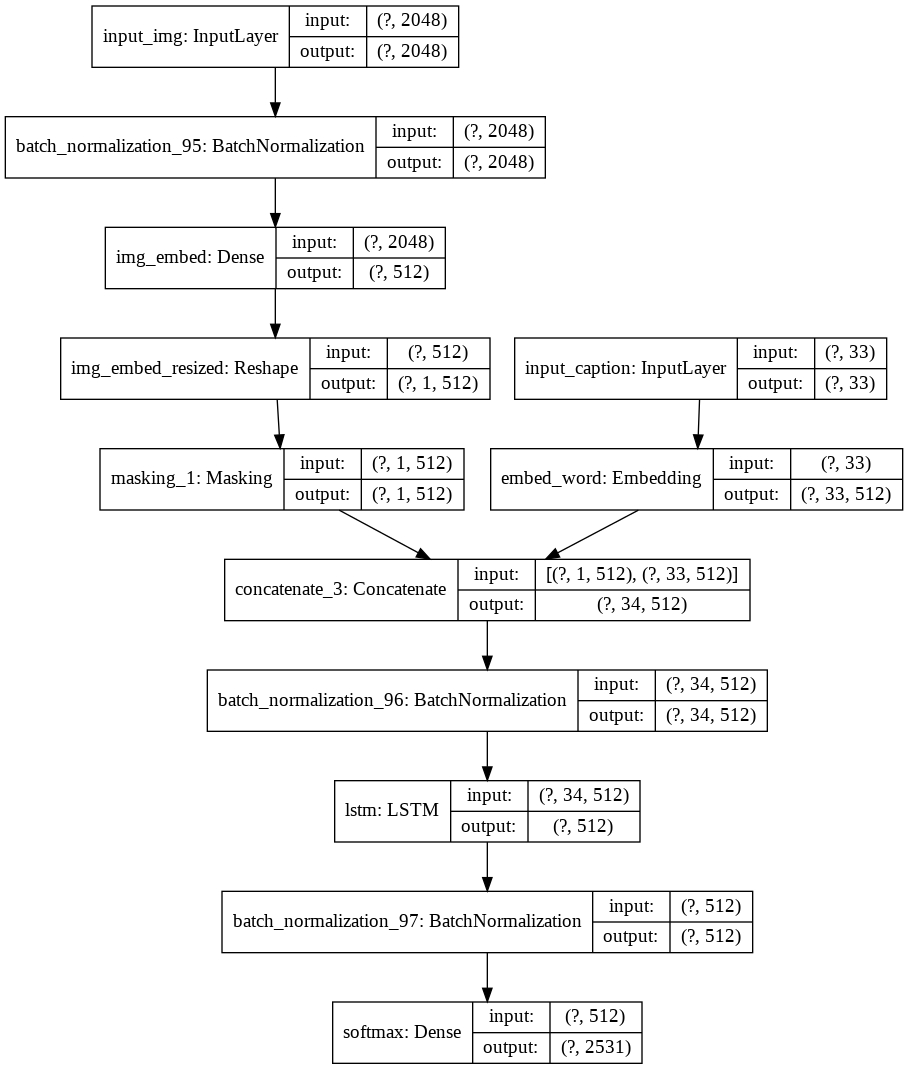

In [ ]:
from tensorflow.keras import utils

utils.plot_model(finalModel, 'Model.png', show_shapes=True)

# Train the final model

Define the data generator function.

In [ ]:
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from numpy import array

# photos_per_batch define how many pictures will be loaded for a single mini-batch
# captions_dict is a mapping of image title -> captions (can be trainImgCaptions, validImgCaptions or testImgCaptions)
# features_dict is a mapping of image title -> features extracted by CNN (can be imgFeaturesTrain, imgFeaturesValid or imgFeaturesTest)
def data_generator(photos_per_batch, captions_dict, features_dict):  
    # define lists that will store inputs and outputs for a single batch         
    batchImgFeatures = list()
    batchPartialCaptures = list()
    batchCorrectWords = list()
    imgCounter = 0
    # loop forever over all images in the specified dataset
    while True:
        # shuffle images so that they appear in different order in different mini-batches 
        imgCaptionsShuffled = np.random.permutation(list(captions_dict.items()))
        for imgTitle, captions in imgCaptionsShuffled:
            imgCounter += 1
            # image features is one of the inputs
            features = features_dict[imgTitle]
            for caption in captions:
                # encode the words of the caption
                encodedCaption = [wordToId[word] for word in caption.split() if word in wordToId]
                # iterate over all timesteps (that is, over all partial captions)
                for timestep in range(1, len(encodedCaption)):
                    # partialCaption is one of the inputs
                    partialCaption = encodedCaption[:timestep]
                    # correctWord is the correct word ID prediction
                    correctWord = encodedCaption[timestep]
                    # pad partialCaption with zeros
                    partialCaption = pad_sequences([partialCaption], maxlen = maxCaptionLength, padding='post')[0]
                    # one-hot encode the correct word ID
                    correctWord = to_categorical([correctWord], num_classes = vocabTrainSize + 1)[0]
                    # store te inputs and output for the current batch
                    batchImgFeatures.append(features)
                    batchPartialCaptures.append(partialCaption)
                    batchCorrectWords.append(correctWord)
            if imgCounter == photos_per_batch:
                # release the batch data
                yield [[array(batchImgFeatures), array(batchPartialCaptures)], array(batchCorrectWords)]
                # clean up the lists before collecting data for the next batch
                batchImgFeatures = list()
                batchPartialCaptures = list()
                batchCorrectWords = list()
                imgCounter = 0

Perform training and validation using data generators

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger

# constants used while training and validating
TRAIN_BATCH_SIZE = 30
TRAIN_STEPS_PER_EPOCH = 200
VALID_BATCH_SIZE = 25
VALID_STEPS_PER_EPOCH = 40
EPOCHS_NUM = 30

#callback for checkpointing model weights after each Tensorflow epoch in a separate Google Drive file.
checkpointFilePath = project_path_drive + "saved_models_v2/weights.{epoch:02d}-{val_loss:.2f}.hdf5"
checkpointCallback = ModelCheckpoint(checkpointFilePath, 
                                      monitor = 'val_loss', 
                                      save_best_only = False, 
                                      save_weights_only = True, 
                                      verbose = 1, 
                                      mode = 'min')

# callback for updating the csv log after each Tensorflow epoch in a Google Drive file.
csvLoggerFilePath = project_path_drive + "saved_models_v2/training_logs/training.log"
csvLoggerCallback = CSVLogger(csvLoggerFilePath, separator=',', append=True)

# data generators for testing and validating
trainGen = data_generator(photos_per_batch = TRAIN_BATCH_SIZE, captions_dict = trainImgCaptions, features_dict = imgFeaturesTrain)
validGen = data_generator(photos_per_batch = VALID_BATCH_SIZE, captions_dict = validImgCaptions, features_dict = imgFeaturesValid)

# fit and validate the model
finalModel.fit_generator(generator = trainGen, 
                         epochs = EPOCHS_NUM, 
                         steps_per_epoch = TRAIN_STEPS_PER_EPOCH,
                         validation_data = validGen,
                         validation_steps = VALID_STEPS_PER_EPOCH,
                         callbacks = [checkpointCallback, csvLoggerCallback],
                         verbose = 1,
                         initial_epoch = 12     # provide this parameter to start from a specific epoch
                         )

Load the model weights from Google Drive (only perform if necessary)

In [ ]:
# ONLY PEFRORM IF NECESSARY
finalModel.load_weights(project_path_drive + "saved_models_v2/weights.23-5.18.hdf5")

Show the learning curve

Last training loss:  5.1801109313964835
Last validation loss:  5.1801109313964835


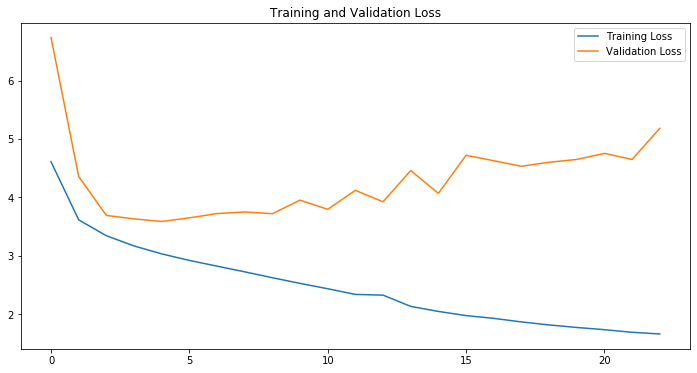

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

LOG_LINES = 23

# Read the first EPOCHS_NUM rows of the training log
log = pd.read_csv(csvLoggerFilePath, nrows = LOG_LINES)

# Read the training and validation loss columns
trainLoss = log['loss']
valLoss = log['val_loss']

# Print the last available training and validation loss
lastTrainLoss = log.at[LOG_LINES - 1, 'loss']
lastValLoss = log.at[LOG_LINES - 1, 'val_loss']
print("Last training loss: ", lastValLoss)
print("Last validation loss: ", lastValLoss)

epochsRange = range(LOG_LINES)

# Print the diagram
plt.figure(figsize=(12, 6))
plt.plot(epochsRange, trainLoss, label='Training Loss')
plt.plot(epochsRange, valLoss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Test the model

Define a function that implements the gready search algorithm. It takes the most probable word at each timestep and appends it to the caption.

In [ ]:
def greedy_search(img_title):
  # get the miage's features
  features = imgFeaturesTest[img_title]
  
  # initialize the partial caption with 'startseq'
  partialCaptionString = "startseq"
  # iterate until the maximal caption length or 'endseq' is encountered
  for cnt in range(maxCaptionLength):
    # word IDs of the current partial caption
    partialCaptionWordIdList = [wordToId[word] for word in partialCaptionString.split()]
    # pad partialCaptionWordIdList with zeros from the right
    partialCaptionWordIdList = pad_sequences([partialCaptionWordIdList], maxlen = maxCaptionLength, padding='post')[0]
    # make the prediction for the next word in the caption
    nextWordPredictions = finalModel.predict([[features], [partialCaptionWordIdList]], verbose = 0)
    # get the ID of the most probable word
    nextWordId = np.argmax(nextWordPredictions)
    nextWord = idToWord[nextWordId]
    # concatente the most probable word to the current partial caption
    partialCaptionString = partialCaptionString + " " + nextWord
    # quit the cycle if 'endseq' is encountered
    if nextWord == "endseq":
      break
  # remove special words 'startseq' and 'endseq' from the cation
  finalCaptionList = partialCaptionString.split()[1:-1]
  return " ".join(finalCaptionList)

# a mapping to store predicted captions for all test images
predictedImgCaptions = dict()

# get predicted captions for all test images
for testImgTitle in testImgList:
  predictedImgCaptions[testImgTitle] = greedy_search(testImgTitle)

Show the number of unique captions

In [ ]:
print("Number of unique captions: %d" % len(set(predictedImgCaptions.values())))

Number of unique captions: 967


Load all test images as arrays of pixels into testLoadedImages

In [ ]:
# load all test images as arrays of pixels into testLoadedImages
testLoadedImages = dict()

for imgTitle in testImgList:
    loadedImg = load_img(images_dir_path + imgTitle)
    imgArray = np.asarray(loadedImg)
    testLoadedImages[imgTitle] = imgArray

Draw several random test images together with their predicted captions

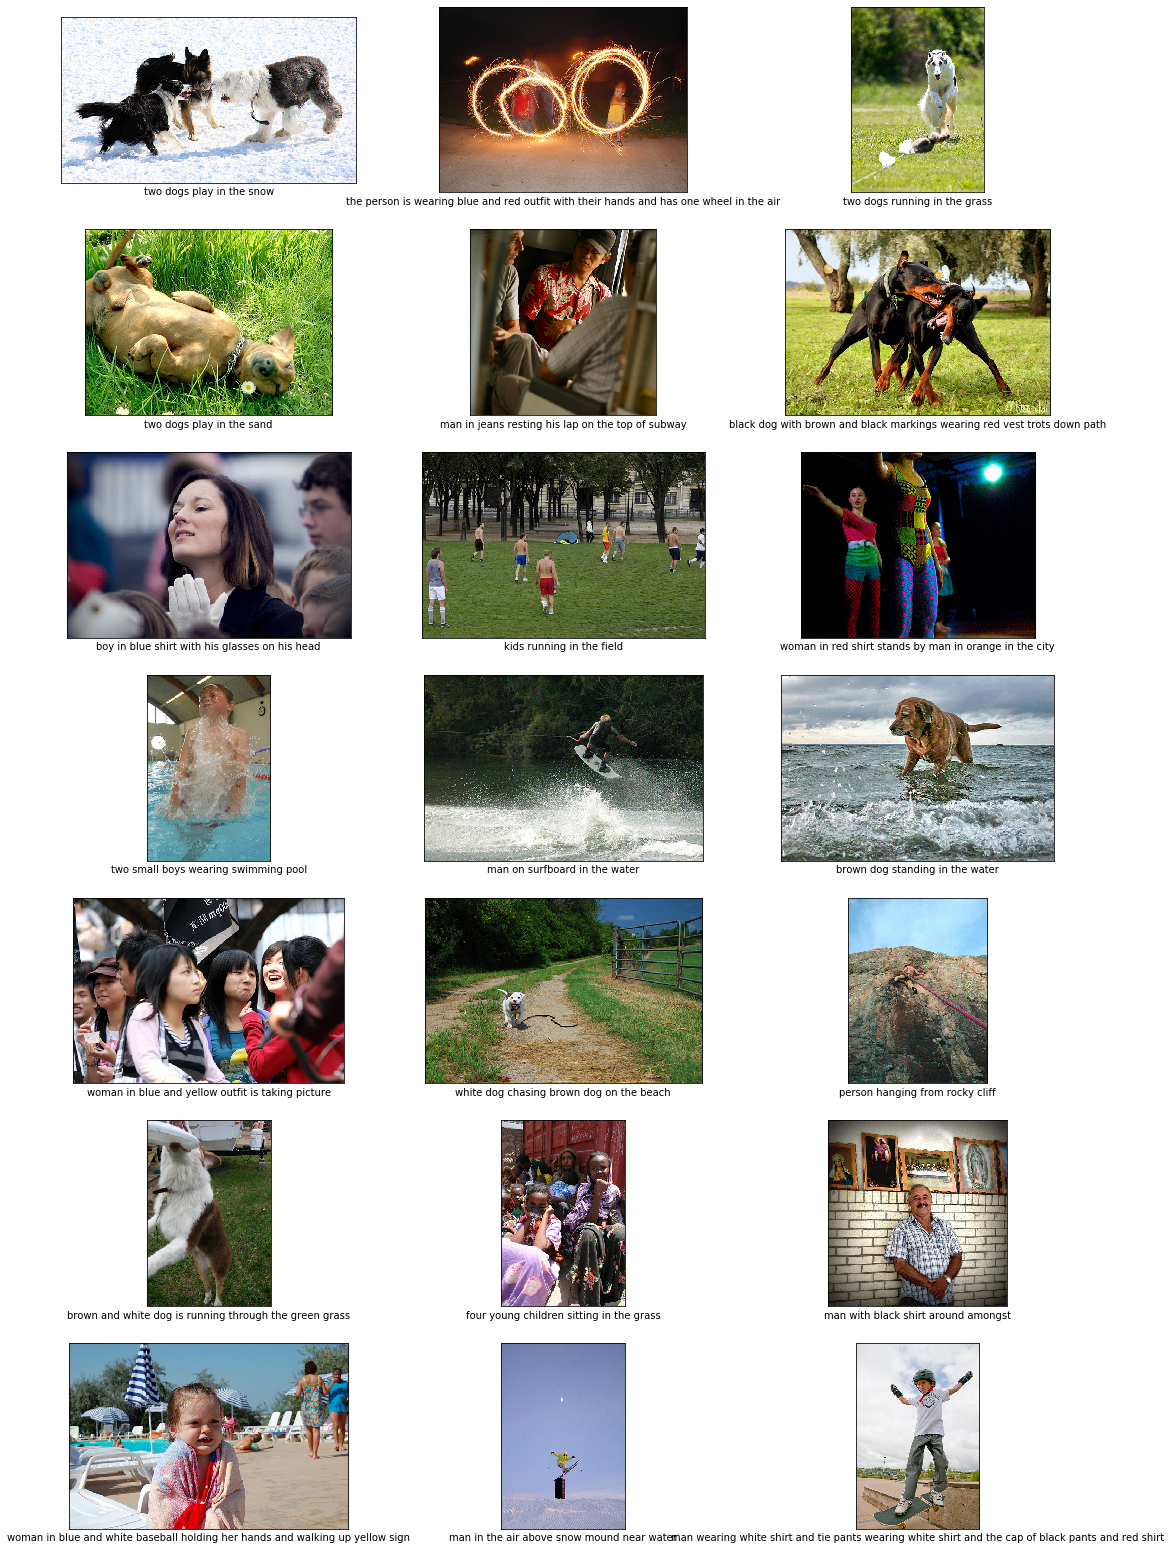

In [ ]:
import numpy as np

# an utility function that draws an image with its caption
def plot_image(testImageTitle):
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(testLoadedImages[testImageTitle], cmap=plt.cm.binary)
    plt.xlabel(predictedImgCaptions[testImageTitle])

# shuffle the test images to obtain random images
shuffledTestImgList = np.random.permutation(testImgList)

numRows = 7
numCols = 3
numImages = numRows * numCols
plt.figure(figsize=(6 * numCols, 4 * numRows))
for i in range(numImages):
  plt.subplot(numRows, numCols, i + 1)
  plot_image(shuffledTestImgList[i])

# Show the result in a (numRows X numCols) grid
plt.show()


# Summary

We see that the captions are completely precise in a quite small number of cases. However, for most pictures the model manages to figure out at least one correct aspect (e.g. a black shirt, relation to sports, presence of a dog etc.). We also notice that for 1000 test images we only have 325 unique captions, meaning that several pictures are generalized to the same captions.

We think that the major reason is model overfitting. On the learning curve graph we notice that after a certain epoch the validation loss stops improving while the training loss improves gradually. In order to decrease overfitting we could add another dropout layer before the softmax layer, or introduce other techniques as batch normalization and regularization. The authors of the "Show and Tell" paper decided to reduce overfitting using ensemble learning, that is training many models on different records. 

Moreover, as the authors emphasize in their conclusion, dataset size plays a crucial role for the model's performance. We used Flickr8k dataset for this lab, which is one of the smallest available image datasets, to reduce the training time. Of course, a bigger dataset would produce better captions.

Another improvement suggested by the paper is implementing a more sophisticated version of search called Beam search, that is preserving several best partial captions after each prediction step. As we only preserve one best matching word at each step, we may reject some words that would lead to more suitable captions overall.